In [1]:
from keras.layers import*
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from scipy import misc
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import h5py
import os
import pandas as pd
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
image_size=(299,299)
width = image_size[0]
height = image_size[1]
input_tensor = Input((height, width, 3))
x = input_tensor
x = Lambda(preprocess_input)(x)
model_inc = InceptionV3(input_tensor=x, weights='imagenet', include_top=False)


for layers in model_inc.layers:
    layers.trainable = False
    
x = GlobalAveragePooling2D()(model_inc.output)
x = Dropout(0.25)(x)
x = Dense(1)(x)

x = Activation('sigmoid')(x)
model = Model(model_inc.input, x)

In [3]:
with h5py.File('train_data.h5', 'r') as h:
    X_train = np.array(h['train'])
    y_train = np.array(h['y_train'])
    X_valid = np.array(h['valid'])
    y_valid = np.array(h['y_valid'])

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
save_model = ModelCheckpoint('inceptionv3{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping,save_model])

Train on 22500 samples, validate on 2500 samples
Epoch 1/20
22500/22500 [==============================] - 1246s - loss: 0.1246 - acc: 0.9535 - val_loss: 0.0546 - val_acc: 0.9832
Epoch 2/20
22500/22500 [==============================] - 1241s - loss: 0.1056 - acc: 0.9612 - val_loss: 0.0474 - val_acc: 0.9840
Epoch 3/20
22500/22500 [==============================] - 1241s - loss: 0.1027 - acc: 0.9617 - val_loss: 0.0473 - val_acc: 0.9816
Epoch 4/20
22500/22500 [==============================] - 1241s - loss: 0.1020 - acc: 0.9621 - val_loss: 0.0514 - val_acc: 0.9804
Epoch 5/20
22500/22500 [==============================] - 1240s - loss: 0.1054 - acc: 0.9611 - val_loss: 0.0485 - val_acc: 0.9800
Epoch 6/20
22500/22500 [==============================] - 1241s - loss: 0.1018 - acc: 0.9617 - val_loss: 0.0465 - val_acc: 0.9812
Epoch 7/20
22500/22500 [==============================] - 1240s - loss: 0.0992 - acc: 0.9631 - val_loss: 0.0506 - val_acc: 0.9812
Epoch 8/20
22500/22500 [=================

In [6]:
import matplotlib.pyplot as plt

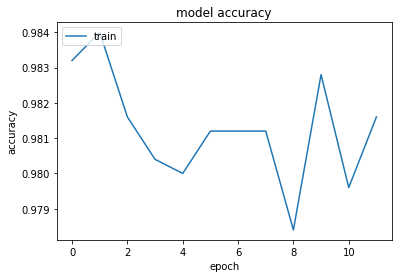

In [7]:
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

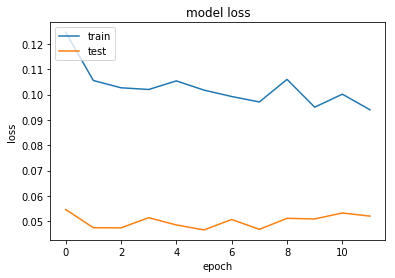

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 模型保存

In [9]:
json_string = model.to_json()
open('inceptionV3.json','w').write(json_string)

147973

# 加载最佳模型

In [10]:
from keras.models import model_from_json

In [11]:
model = model_from_json(open('inceptionV3.json').read())
model.load_weights('inceptionv305-0.05.h5')

# 预测结果

In [13]:
n = 25000
filenames = os.listdir('../test')
file_ob_path = [os.path.join('../test',file) for file in filenames]
n = len(file_ob_path)

X_test = np.zeros((n, 299, 299, 3), dtype=np.uint8)


for i in tqdm(range(n)):
    X_test[i] = misc.imresize(misc.imread(file_ob_path[i]), (299,299))

100%|██████████| 12500/12500 [01:48<00:00, 115.06it/s]


In [14]:
y_pred = model.predict(X_test,batch_size=16, verbose=1)

12500/12500 [==============================] - 680s   


In [15]:
y_pred = y_pred.clip(min=0.005, max=0.995)
_id = [int(i.split('.')[0]) for i in filenames]

In [16]:
df = pd.DataFrame({'id':_id,'label':y_pred.squeeze()})
df = df.sort_values(by='id')
df.to_csv('sample_submission_inV3.csv',index=False)

In [ ]:
# 结果为0.06620

# Fine-tune

In [ ]:
model = model_from_json(open('inceptionV3.json').read())
model.load_weights('inceptionv305-0.05.h5')

In [3]:
with h5py.File('train_data.h5', 'r') as h:
    X_train = np.array(h['train'])
    y_train = np.array(h['y_train'])
    X_valid = np.array(h['valid'])
    y_valid = np.array(h['y_valid'])

In [4]:
#list(zip([x.name for x in model.layers], range(len(model.layers))))

In [17]:
for layer in model.layers[:258]:
    layer.trainable = False
for layer in model.layers[258:]:
    layer.trainable = True

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
auto_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0, 
                            mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
save_model = ModelCheckpoint('Inception_V3{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)
optimizer=Adam(lr=0.001)
model.compile(optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [19]:
history_1 = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_valid, y_valid),
                      callbacks=[early_stopping,auto_lr,save_model])

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 1475s - loss: 0.0709 - acc: 0.9776 - val_loss: 0.0322 - val_acc: 0.9868
Epoch 2/10
22500/22500 [==============================] - 1463s - loss: 0.0341 - acc: 0.9879 - val_loss: 0.0248 - val_acc: 0.9904
Epoch 3/10
22500/22500 [==============================] - 1463s - loss: 0.0280 - acc: 0.9900 - val_loss: 0.0189 - val_acc: 0.9928
Epoch 4/10
22500/22500 [==============================] - 1463s - loss: 0.0201 - acc: 0.9929 - val_loss: 0.0294 - val_acc: 0.9908
Epoch 5/10
22500/22500 [==============================] - 1463s - loss: 0.0217 - acc: 0.9929 - val_loss: 0.0211 - val_acc: 0.9924
Epoch 6/10
22500/22500 [==============================] - 1463s - loss: 0.0163 - acc: 0.9944 - val_loss: 0.0298 - val_acc: 0.9904
Epoch 7/10
22500/22500 [==============================] - 1463s - loss: 0.0143 - acc: 0.9952 - val_loss: 0.0216 - val_acc: 0.9920


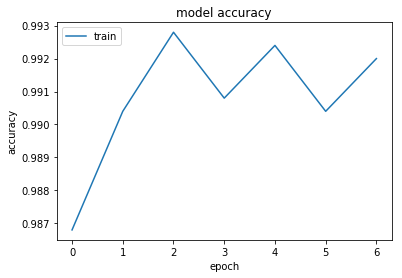

In [20]:
plt.plot(history_1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

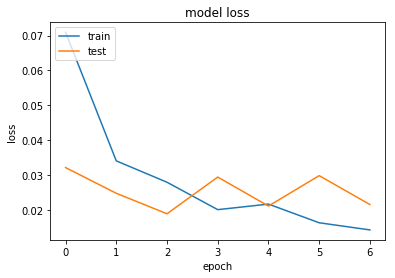

In [21]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# 加载最佳模型

In [22]:
model = model_from_json(open('inceptionV3.json').read())
model.load_weights('Inception_V302-0.02.h5')

In [17]:
# 预测结果

In [26]:
filenames = os.listdir('../test')
file_ob_path = [os.path.join('../test',file) for file in filenames]
n = len(file_ob_path)

X_test = np.zeros((n, 299, 299, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    X_test[i] = misc.imresize(misc.imread(file_ob_path[i]), (299,299))


100%|██████████| 12500/12500 [01:45<00:00, 118.22it/s]


In [27]:
y_pred = model.predict(X_test,batch_size=16, verbose=1)

12500/12500 [==============================] - 679s   


In [28]:
y_pred = y_pred.clip(min=0.005, max=0.995)
_id = [int(i.split('.')[0]) for i in filenames]
df = pd.DataFrame({'id':_id,'label':y_pred.squeeze()})
df = df.sort_values(by='id')
df.to_csv('sample_submission_inV3_fn.csv',index=False)

In [ ]:
# 结果

In [1]:
#0.05190